<a href="https://colab.research.google.com/github/jojoroy/MScDis/blob/main/GPMHLotkaVolterra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

#### Approach 2: $L^2$ between the scores.

Ultimately, we want the surrogate model to perform MCMC.  If we're using a gradient based approach, then only really care about the score function, i.e. the gradient of the log likelihood.   It makes sense to consider a loss function which is only penalising errors in the gradient -- this has a lot of advantages:  we no longer have to worry about the normalisation constant, and it simplifies some calculations significantly.

We consider an optimal estimator for the score function $\nabla \log \pi_f$, i.e.
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int |\nabla \log \widetilde{\pi}_1(x) - \nabla \log \widetilde{\pi}_2(x)|^2.
$$
The optimal estimator is then
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\nabla \log\widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\nabla \log \widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator then satisfies
$$
\nabla \log \widetilde{\pi}^*(x) = \nabla \mathbb{E}_{f | D } f(x) = \nabla  m(x),
$$
so that
$$
    \widetilde{\pi}^*(x) \propto e^{m(x)}.
$$
The risk / variance of the estimator is
$$
    \mathbb{E}_{f|D}\int |\nabla \log \pi_f(x) - \nabla m(x)|^2 \,dx =  \mathbb{E}_{f|D}\int |\nabla f(x)- \nabla m(x)|^2 \,dx,
$$
which is
$$
    \int Tr(Cov(\nabla f(x) |D))\,dx = \int \nabla_1 \cdot \nabla_2 k_{D}(x, x)\,dx.
$$
The most important point is that this term is independent of the evaluations of the true posterior.  This means that no active learning is feasible in this instance, and instead we would do a single offline point evaluation stage.


#### Approach 3: Distances between the measures

An alternative approach which constrasts with the local one considered previously, would be to require that the estimator is close to the surrogate in terms of distances on probability distributions.  For example, we could use KL divergence.

Consider
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(d, \pi_f) \\
 &=  \int d(x) \log d(x)\,dx - \int d(x) m_n(x)\,dx,
 \end{aligned}
$$
using the fact that $\int d(x)\,dx = 1$.  This has minimiser:
$$
d^*(x) \propto e^{m_n(x)}
$$

The risk is
$$
\mathbb{E}_{f|D}KL(d^*, \pi_f) = \int\frac{ e^{m_n(x)}}{Z_n}  m_n(x)\,dx - \int \frac{e^{m_n(x)}}{Z_n} m_n(x)\,dx = 0.
$$

(Am I making a mistake here?  This seems unlikely to be true?)

Alternatively, we could consider the Reverse-KL as a loss
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(\pi_f, d) \\
 &=   \mathbb{E}_{f|D}\left[\int \pi_f \log \pi_f\,dx - \int \pi_f \log d(x)\,dx\right], \\
 &=   \int \mathbb{E}_{f|D}[\pi_f \log \pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C +  \int \mathbb{E}_{f|D}[\pi_f] \log \mathbb{E}_{f|D}[\pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C + KL(\mathbb{E}_{f|D}[\pi_f] , d),
 \end{aligned}
$$
where $C$ is a constant.  The optimal estimator is therefore
$$
d^* = \mathbb{E}_{f|D}[\pi_f].
$$

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

In [ ]:
import arviz as az
#import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

#from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

In [ ]:
pip install jaxtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
pip install gpjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: optax
    Found existing installation: optax 0.2.2
    Uninstalling optax-0.2.2:
      Successfully uninstalled optax-0.2.2


In [ ]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
import numpy as np
#from jax.scipy.special import log1p

In [ ]:
# Define the function to be sampled from.

# this is the log-likelihood of a Gaussian mixture with means at -2 and 2 and variance 0.1
l = jit(lambda x:  jnp.log(0.5 * jnp.exp(-(x-2)**2/0.2) + 0.5 * jnp.exp(-(x +2)**2/ 0.2)))

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = l(xtest)

D = gpx.Dataset(xtest, ytest)

This is just some test code to check that the Gaussian process does regression properly.

In [ ]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


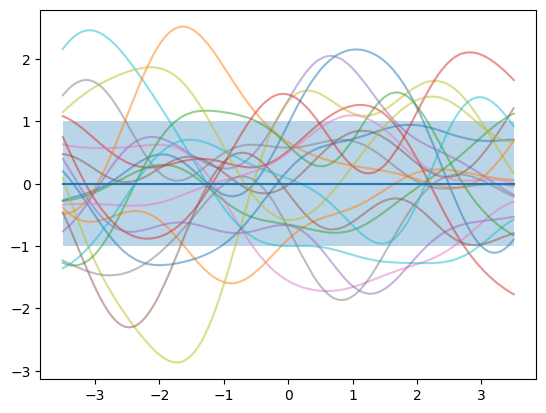

In [ ]:
# generate some test points
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)

# predict from the prior
prior_dist = prior.predict(xtest)

# generate samples from the prior and do prediction
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))

# plot the prior samples
fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest, prior_mean,  label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)
# ax.legend(loc="best")

In [ ]:
# Generate the likelihood

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

# Generate the posterior predictive distribution
latent_dist = posterior.predict(xtest, train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

# Extract the mean and variance of the posterior predictive distribution
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=obs_stddev)
    posterior = prior * likelihood

    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [ ]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    kernel = posterior.prior.kernel
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * obs_noise

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = kernel.cross_covariance(X, Y)
    KXx = kernel.cross_covariance(X, x_current)
    KxY = kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)

    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

## 2023 paper

In [ ]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [ ]:
# This removes the terms that don't depend on x_new
def loss_2023papernew(posterior,x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    #D = gpx.Dataset(x_current, y_current)

    #posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [ ]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
#PRONE TO INSTABILITY
def expected(m,v):
  if m>=0:
    return norm.cdf(-m/v)-jnp.exp(u+(v**2)/2)*norm.cdf(-(m+v**2)/v)
  else:
    return norm.cdf(m/v)+jnp.exp(u+(v**2)/2)*(norm.cdf(-(m+v**2)/v)-2*norm.cdf(-v))

In [ ]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [ ]:
# define x current and y_current
x_current = jnp.array([[-5., 5.]]).T
y_current = l(x_current)
# set up empty mh_samples
N = 10
mh_samples=np.zeros(N)
mh_samples[0]=0
epsilon = 0.3
obs_stddev=1e-3

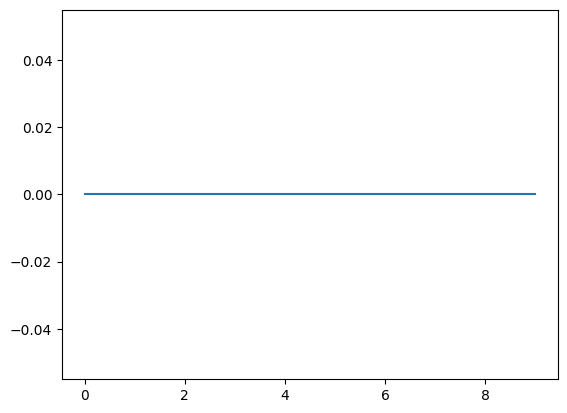

In [ ]:
plt.plot(mh_samples)

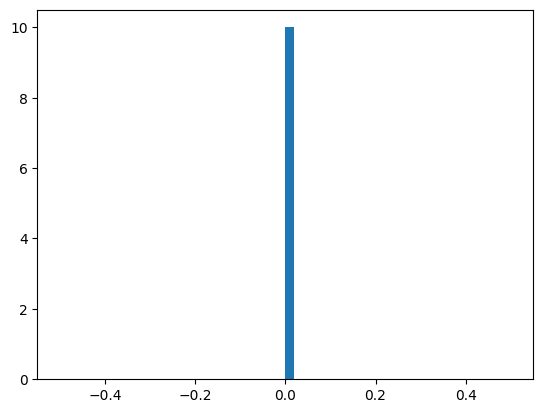

In [ ]:
plt.hist(mh_samples,bins=50)
plt.show()

(-100.0, 10.0)

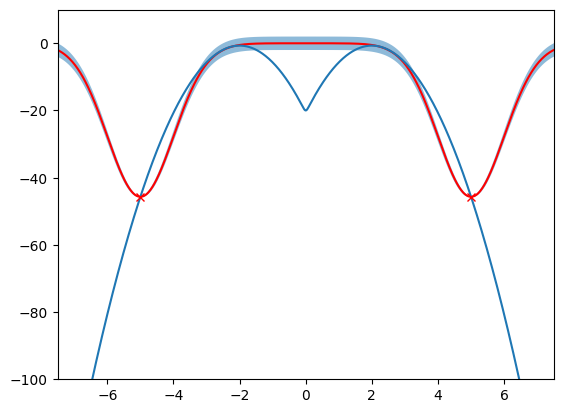

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-10.0, 10.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
plt.xlim(-7.5,7.5)
plt.ylim(-100,10)

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

## 2D STUFF

In [ ]:
import jax.numpy as jnp
from jax import jit

# Define the PDF of a bivariate normal distribution
def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho):
    sigma_x2 = sigma_x ** 2
    sigma_y2 = sigma_y ** 2
    rho2 = rho ** 2
    one_minus_rho2 = 1 - rho2

    z = ((x - mu_x) ** 2 / sigma_x2 +
         (y - mu_y) ** 2 / sigma_y2 -
         2 * rho * (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y))

    normalization = 1 / (2 * jnp.pi * sigma_x * sigma_y * jnp.sqrt(one_minus_rho2))
    return normalization * jnp.exp(-z / (2 * one_minus_rho2))

# Define the log-likelihood function for a mixture of two bivariate normal distributions
def create_log_likelihood(mu_x1, mu_y1, sigma_x1, sigma_y1, rho1,
                          mu_x2, mu_y2, sigma_x2, sigma_y2, rho2, weight):
    @jit
    def log_likelihood(coordinate_pairs):
        # Split the coordinate pairs into x and y arrays
        coordinates = jnp.array(coordinate_pairs)
        x = coordinates[:, 0]
        y = coordinates[:, 1]

        # Compute the PDFs for each component
        pdf1 = bivariate_normal_pdf(x, y, mu_x1, mu_y1, sigma_x1, sigma_y1, rho1)
        pdf2 = bivariate_normal_pdf(x, y, mu_x2, mu_y2, sigma_x2, sigma_y2, rho2)

        # Combine the PDFs using the mixture weight
        combined_pdf = weight * pdf1 + (1 - weight) * pdf2

        # Compute the log-likelihood for each pair
        log_likelihood = jnp.log(combined_pdf)
        return log_likelihood

    return log_likelihood

# Example data
coordinate_pairs = [(1.0, 1.5), (2.0, 2.5), (3.0, 3.5)]

# Example parameters
mu_x1, mu_y1, sigma_x1, sigma_y1, rho1 = 2.0, 2.0, 1.0, 1.0, 0
mu_x2, mu_y2, sigma_x2, sigma_y2, rho2 = 4.0, 4.5, 1.0, 1.0, 0
weight = 1.

# Create the log-likelihood function with fixed parameters
log_likelihood_fn = create_log_likelihood(mu_x1, mu_y1, sigma_x1, sigma_y1, rho1,
                                          mu_x2, mu_y2, sigma_x2, sigma_y2, rho2, weight)

# Compute log-likelihoods for each coordinate pair
ll_values = log_likelihood_fn(coordinate_pairs)
print("Log-Likelihoods:", ll_values)


Log-Likelihoods: [-2.46287707 -1.96287707 -3.46287707]


In [ ]:
from jax.scipy.stats import multivariate_normal as mvn
#rv = mvn([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
log_likelihood_fn=jit(lambda x:mvn.logpdf(x,mean=jnp.array([2.,2.]),cov=jnp.array([[1.,0.],[0.,1.]])))

In [ ]:
log_likelihood_fn(jnp.array([2.,2.]))

Array(-1.83787707, dtype=float64)

In [ ]:
# define x current and y_current
x_current = jnp.array([[1.0, 1.5], [2.0, 2.0], [3.0, 3.5]])
y_current = jnp.array(log_likelihood_fn(x_current).reshape(-1,1))
# set up empty mh_samples
N = 100
mh_samples=np.zeros((N,2))
mh_samples[0,0]=3
mh_samples[0,1]=3
epsilon = 0.5
obs_stddev=1e-3
proposal='uniform'

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack((x_now,x_prop))

  #x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
  #print( x_eval[0], x_eval[1],x_current)
  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  C1 = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[0]]), posterior)
  C2= two_point_covariance(x_current, jnp.array([x_eval[1]]), jnp.array([x_eval[1]]), posterior)
  print(v**2-posterior.likelihood.obs_stddev**2,C,C1,C2)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
D = gpx.Dataset(x_current, y=y_current)

posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform(0,1,2) - 0.5)*1 + mh_samples[i-1,:]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now=mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)

  m,v = gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev,D)

  print('step',i,epsilon_gamma(m,v,u),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while (expected1(m,v) > jnp.log(epsilon) and epsilon_gamma(m,v,u)>0.1) and np.size(x_current) < 400:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    x_grid = jnp.vstack([x_now,x_prop])#.reshape(-1,1)

    test_points = jnp.arange(-7.5, 7.5, 0.1)
    test_points=jnp.array([[1.,1.],[2.,2.],[-1.,-1.]])
    x_range = jnp.arange(start = 1., stop = 6., step = 0.25 )
    y_range = jnp.arange(start = 1., stop = 6., step = 0.25 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points= jnp.round(test_points,1)
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(x_current, y_current, test_points, x_grid, key, obs_stddev)
    '''
    temp_flag = np.any(test_point_utilities)
    while temp_flag == False:
      test_points = jnp.arange(-7.5, 7.5, 0.1)
      test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
      #print(np.shape(test_points))
      test_point_utilities = loss_2023paper(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)
      temp_flag = np.any(test_point_utilities)
    '''
    j = jnp.argmax(jnp.array(test_point_utilities))
    x_new = test_points[j]

    x_current = jnp.vstack([x_current, x_new])
    ##x_current = x_current.sort(axis=0)
    y_current = log_likelihood_fn(x_current).reshape(-1,1)
    #y_current = jnp.vstack([y_current, y_new])
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,x_current,x_prop,x_now,key,obs_stddev, D)
    print('chosen new point',x_new,'size',np.shape(x_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = x_prop
  else:
    mh_samples[i] = mh_samples[i-1]





  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


[[0.28687237]
 [0.30015025]] [[0.27349512]] [[0.28687103]] [[0.30014891]]
step 1 [[0.16834027]] 1.2068499264990316 Current [3. 3.] proposed [2.54626129 3.49334026]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.84270017]
 [1.88535226]] [[1.83728143]] [[1.84269913]] [[1.88535123]]
chosen new point [5.8 1. ] size (4, 2) 1.1819288723375236


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.0300592 ]
 [2.03205396]] [[1.98139157]] [[2.03005818]] [[2.03205293]]
chosen new point [1.  5.8] size (5, 2) 1.844752766472408


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.65929998]
 [1.68580019]] [[1.65490424]] [[1.65929895]] [[1.68579915]]
chosen new point [5. 1.] size (6, 2) 1.0394329115794538


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.17602695]
 [0.28036564]] [[-0.08965547]] [[0.17602513]] [[0.28036382]]
chosen new point [1.  5.8] size (7, 2) 4.723772142773954


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.23103002]
 [0.08677639]] [[0.0922025]] [[0.23102736]] [[0.08677483]]
chosen new point [2.5 3.8] size (8, 2) 2.698892586843484


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.03890104]
 [0.05194036]] [[0.04232845]] [[0.03889949]] [[0.05193874]]
chosen new point [3.2 2.5] size (9, 2) 0.4747968575822992
m [-0.17928419] v [[0.00618449]] 0.821588900105254
[[0.05194036]
 [0.20171955]] [[0.09258833]] [[0.05193874]] [[0.2017168]]
step 2 [[8.87480896e-14]] 1.1430438257084385 Current [2.54626129 3.49334026] proposed [2.18912958 3.43423576]
m [0.22579421] v [[0.06848325]] 0.154399526040782
[[0.20171955]
 [0.66053393]] [[0.34367555]] [[0.2017168]] [[0.66053084]]
step 3 [[0.02499973]] 1.0745334955845127 Current [2.18912958 3.43423576] proposed [1.7738838  3.07105788]
m [0.56920373] v [[0.17490238]] 0.55898289510614
[[0.66053393]
 [0.64982419]] [[0.64594941]] [[0.66053084]] [[0.64982001]]
step 4 [[2.53017409e-05]] 1.120310422515912 Current [1.7738838  3.07105788] proposed [1.7459372  3.32913775]
m [-0.3094199] v [[0.0184593]] 0.5528458596937093
[[0.64982419]
 [0.71758417]] [[0.61276629]] [[0.64982001]] [[0.71757717]]
step 5 [[0.02523181]] 3.4666113998925745 Current 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.0437057 ]
 [0.04252028]] [[0.04224749]] [[0.04370332]] [[0.04251708]]
chosen new point [1.8 3.5] size (10, 2) 0.17955593202485617
m [-0.26918697] v [[0.001731]] 0.9846754371451389
[[0.0437057 ]
 [0.00117073]] [[0.00707305]] [[0.04370332]] [[0.00116875]]
step 11 [[0.10126738]] 0.3882378297536594 Current [1.75508737 3.85069455] proposed [1.78831386 3.55664089]
m [0.63583209] v [[0.03073032]] 0.894102450556211
[[0.00117073]
 [0.03528431]] [[-0.00566352]] [[0.00116875]] [[0.03528117]]
step 12 [[0.0008098]] 0.4450255144270563 Current [1.78831386 3.55664089] proposed [1.73454587 3.06964343]
m [0.70350311] v [[0.04778208]] 0.5854954791573523
[[0.03528431]
 [0.00653386]] [[-0.00890954]] [[0.03528117]] [[0.00653159]]
step 13 [[3.53840864e-06]] 2.4309344932253056 Current [1.73454587 3.06964343] proposed [1.68322952 3.54769574]
m [-0.6876874] v [[0.05963725]] 0.2823062426400278
[[0.00653386]
 [0.09145005]] [[0.014469]] [[0.00653159]] [[0.09144484]]
step 14 [[0.19375248]] 0.7558485540137275 Cu

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.00374858]
 [0.00379182]] [[0.00350737]] [[0.00374657]] [[0.00379009]]
chosen new point [1.2 3. ] size (11, 2) 0.005530551913576662
m [0.30356036] v [[0.00052565]] 0.9099471420551477
[[0.00379182]
 [0.01414163]] [[0.00668057]] [[0.00379009]] [[0.01413956]]
step 15 [[5.43898538e-214]] 0.5715906074937557 Current [1.31797447 3.22839615] proposed [1.64226151 3.64042785]
m [-0.49632709] v [[0.00457231]] 0.11727617842990601
[[0.01414163]
 [0.13673602]] [[0.0427583]] [[0.01413956]] [[0.13673375]]
step 16 [[0.01626005]] 2.352374513899922 Current [1.64226151 3.64042785] proposed [1.24794535 3.78078449]
m [-0.51527574] v [[0.06536105]] 0.5074684123649132
[[0.13673602]
 [0.09255917]] [[0.11236106]] [[0.13673375]] [[0.09255697]]
step 17 [[2.47524135e-13]] 0.22749382134976048 Current [1.24794535 3.78078449] proposed [1.33014482 3.73273739]
m [0.16011161] v [[0.00457308]] 0.6201017514819981
[[0.09255917]
 [0.0079885 ]] [[0.02656002]] [[0.09255697]] [[0.00798645]]
step 18 [[7.63769185e-15]] 0.7064

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.00307559]
 [0.00127537]] [[0.00192828]] [[0.00307395]] [[0.00127354]]
chosen new point [1.5 4.5] size (12, 2) 0.08293338868472325
m [-0.92084698] v [[0.00049439]] 0.9114652320635905
[[0.00307559]
 [0.00248786]] [[0.00275652]] [[0.00307395]] [[0.00248619]]
step 22 [[0.]] 1.172241909781078e-11 Current [1.69786134 3.93276685] proposed [1.61294625 4.17951479]
m [-0.54223524] v [[5.04014956e-05]] 0.5301594240623413
[[0.00248786]
 [0.00346953]] [[0.00292662]] [[0.00248619]] [[0.00346789]]
step 23 [[1.53837784e-140]] 2.254092523797118e-08 Current [1.61294625 4.17951479] proposed [1.66509235 3.98357479]
m [0.44352194] v [[0.00010415]] 0.7766600264973887
[[0.00346953]
 [0.00215838]] [[0.00272745]] [[0.00346789]] [[0.00215667]]
step 24 [[2.45434561e-302]] 0.000409126543805469 Current [1.66509235 3.98357479] proposed [1.59176639 4.22210392]
m [-0.55310749] v [[0.00017301]] 0.6090345961033256
[[0.00346953]
 [0.00841657]] [[-0.00092596]] [[0.00346789]] [[0.00841376]]
step 25 [[1.13379194e-09]] 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[9.40821790e-05]
 [3.26043292e-04]] [[0.00016521]] [[9.22261342e-05]] [[0.00032207]]
chosen new point [2.5 4. ] size (13, 2) 5.395447571756893e-07
m [-0.53888561] v [[8.97098655e-05]] 0.8784656027363347
[[9.40821790e-05]
 [8.09983124e-05]] [[8.52608318e-05]] [[9.22261342e-05]] [[7.91348003e-05]]
step 45 [[0.]] 4.578890221730629e-128 Current [2.78465817 3.65985347] proposed [2.8278626  3.62377073]
m [0.02278206] v [[4.5588279e-06]] 0.6223471067475063
[[8.09983124e-05]
 [7.41359033e-04]] [[4.49125933e-05]] [[7.91348003e-05]] [[0.0007349]]
step 46 [[7.64133827e-125]] 0.010613376541692728 Current [2.8278626  3.62377073] proposed [2.73569787 3.37122476]
m [0.40906259] v [[0.00073253]] 0.5318707745912078
[[0.00074136]
 [0.00056929]] [[0.00060204]] [[0.0007349]] [[0.00056391]]
step 47 [[0.]] 2.646525042054933e-07 Current [2.73569787 3.37122476] proposed [2.34401937 3.48303942]
m [0.0465596] v [[0.00010657]] 0.657666719012745
[[0.00056929]
 [0.00031056]] [[-0.00034825]] [[0.00056391]] [[0.000

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.00173989]
 [0.00039518]] [[0.00058196]] [[0.00173702]] [[0.00039217]]
chosen new point [3.5 3.2] size (14, 2) 0.16590433838105367
m [-0.66222007] v [[0.00097116]] 0.9967280188201416
[[0.00173989]
 [0.00082703]] [[0.0011651]] [[0.00173702]] [[0.00082433]]
step 66 [[0.]] 0.0013731093161415196 Current [3.081252   2.84613145] proposed [3.1085817  3.16978803]
m [-0.3390011] v [[0.00023672]] 0.28058188170385223
[[0.00082703]
 [0.0002099 ]] [[0.00041164]] [[0.00082433]] [[0.00020762]]
step 67 [[0.]] 0.00034651573143709827 Current [3.1085817  3.16978803] proposed [2.99449563 3.37665324]
m [-0.11688752] v [[0.00021365]] 0.2503191958988088
[[2.09896441e-04]
 [6.25342805e-05]] [[9.91922577e-05]] [[0.00020762]] [[6.06926161e-05]]
step 68 [[8.91590369e-09]] 2.798227158870723e-09 Current [2.99449563 3.37665324] proposed [3.15611586 3.355223  ]
m [-0.13247328] v [[7.40462059e-05]] 0.9516082780319997
[[0.0002099 ]
 [0.00365554]] [[0.00076308]] [[0.00020762]] [[0.00365045]]
step 69 [[1.56436736e-12

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[6.34324333e-04]
 [2.51247778e-05]] [[-1.93057133e-05]] [[0.00062793]] [[2.3264268e-05]]
chosen new point [4.  3.5] size (15, 2) 0.17577844578431198
m [-1.00429497] v [[0.00069806]] 0.9070979631229537
[[0.00063432]
 [0.00612856]] [[0.00155882]] [[0.00062793]] [[0.00609756]]
step 98 [[0.15307482]] 0.732301816312821 Current [3.69630723 3.06713444] proposed [4.18747296 3.29473652]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.71988584e-04]
 [7.32934359e-05]] [[4.66016242e-05]] [[0.00016805]] [[7.06177323e-05]]
chosen new point [4.5 3.2] size (16, 2) 0.001658283930138085
m [-1.22259431] v [[0.00015208]] 0.9883703384862015
[[0.00017199]
 [0.00111598]] [[0.00042969]] [[0.00016805]] [[0.00110937]]
step 99 [[3.6742592e-41]] 0.013774206001941148 Current [3.69630723 3.06713444] proposed [3.88765445 2.97096842]
m [-0.27399277] v [[0.00042858]] 0.7536839847000584


In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
x_range = jnp.arange(start = 1., stop = 6., step = 0.1)
y_range = jnp.arange(start = 1., stop = 6., step = 0.1 )

x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
xtest = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#pc=ax.pcolormesh(x_gridvalues, y_gridvalues, p_mean.reshape(15,15))
pc=ax.contour(x_gridvalues, y_gridvalues, p_mean.reshape(50,50))
fig.colorbar(pc)
plt.show()


ValueError: Inputs, X, and outputs, y, must have the same number of rows. Got X.shape=(114, 2) and y.shape=(113, 1).

## Lotka Volterra

In [1]:
# what is the lotka-volterra likelihood
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data using known parameters
def generate_synthetic_data(true_params, initial_conditions, t):
    return odeint(lotka_volterra, initial_conditions, t, args=tuple(true_params))

# Define the likelihood function
def log_likelihood(log_params, t, data, initial_conditions):
    params=np.exp(log_params)
    alpha, beta, delta, gamma = params
    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    return -np.sum(error**2) / 2

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width):
    params = np.array(initial_params)
    log_likelihood_current = log_likelihood(params, t, data, initial_conditions)
    samples = [params]

    for i in range(n_iterations):
        # Propose new parameters
        params_new = params + (np.random.uniform(0,1, size=params.shape)-0.5)*proposal_width
        log_likelihood_new = log_likelihood(params_new, t, data, initial_conditions)

        # Acceptance criterion
        if np.log(np.random.rand()) <log_likelihood_new - log_likelihood_current:
            params = params_new
            log_likelihood_current = log_likelihood_new


        samples.append(params)

    return np.array(samples)




In [11]:
# True parameters for generating synthetic data
true_params = [2.0, 0.1, 0.1, 1.5]
initial_conditions = [10, 5]
t = np.linspace(0, 50, 500)
data = generate_synthetic_data(true_params, initial_conditions, t)

In [17]:


# Initial guess for parameters
initial_params = [0,0,0,0] #[1.0, -2.0, -2.0, 0.0]
n_iterations = 10000
proposal_width = [0.5,
                  0.5,
                  0.5,
                  0.5]

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width)




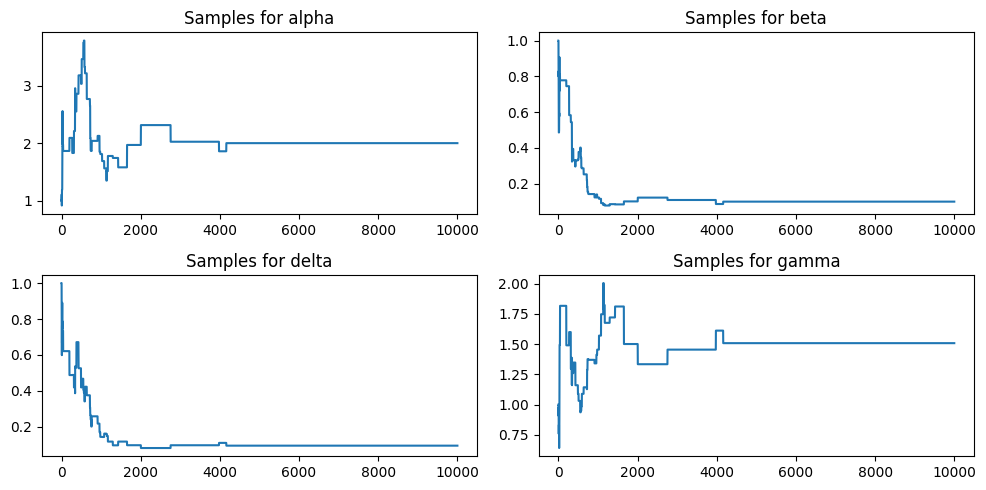

[2.002411   0.10029271 0.09499105 1.5079579 ]


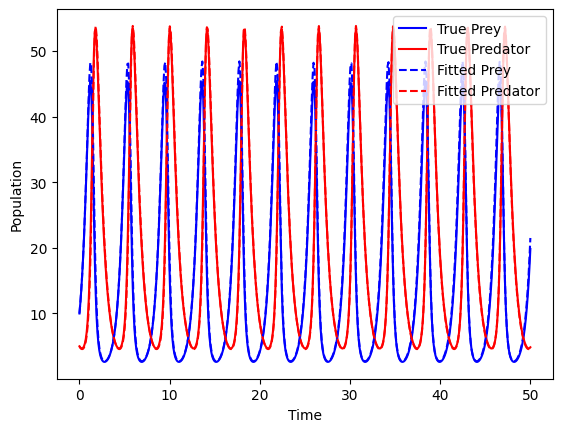

In [18]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(np.exp(samples[:, i]))
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()

# Plot the fitted model vs true data
best_params = samples[np.argmax([log_likelihood(p, t, data, initial_conditions) for p in samples])]
fitted_model = generate_synthetic_data(np.exp(best_params), initial_conditions, t)
print(np.exp(best_params))
plt.figure()
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

# thoughts for likelihood
simulate likelihood for the data given different parameters
choosing new points means choosing new parameters to fit the model
if u want the likelihood to be normal

In [ ]:
# Define the likelihood function


# Define the likelihood function
def log_likelihood_lv(params):#, t, data, initial_conditions):
    alpha=params[:,0]
    beta=params[:,1]
    delta= 0.1
    gamma=1.5

    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    return -np.sum(error**2) / 2

In [ ]:
def log_likelihood_lv(params):#, t, data, initial_conditions):
    alpha = params[:, 0][:, np.newaxis]
    beta = params[:, 1][:, np.newaxis]
    delta = 0.1
    gamma = 1.5

    def model_eq(X, t, alpha, beta):
        x, y = X
        dxdt = alpha * x - beta * x * y
        dydt = delta * x * y - gamma * y
        return [dxdt, dydt]

    # Vectorized integration for all parameter sets
    def integrate_model(alpha, beta):
        model = odeint(model_eq, initial_conditions, t, args=(alpha, beta))
        return model

    # Apply integration for each parameter set
    models = np.array([integrate_model(alpha_i, beta_i) for alpha_i, beta_i in zip(alpha, beta)])

    # Compute error for each parameter set
    sigma=10
    errors = data - models
    log_likelihoods = -np.sum(errors**2, axis=(1, 2)) / 2*sigma**2
    return log_likelihoods

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta = params
    delta=0.1
    gamma=1.5
    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=1
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05], [2.0, 0.1],[1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-2.07489876e+05 -2.51908776e-22 -2.78761503e+05]


In [ ]:
# define x current and y_current
params_current = jnp.array([[1.0, 0.1], [2.0, 0.2], [1.5, 0.3],[0.1,0.1]])
true_params = jnp.array([2.0, 0.1])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 100
mh_samples=np.zeros((N,2))
mh_samples[0,0]=3.0
mh_samples[0,1]=1.0
epsilon = 0.1
obs_stddev=1e-1
proposal='uniform'

In [ ]:
y_current

Array([[-163336.97617133],
       [-158622.37394401],
       [-198245.35185141],
       [-216505.26507197]], dtype=float64)

In [ ]:
D = gpx.Dataset(params_current, y=y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,2) - 0.5)*0.5 + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_prop,params_now,key,obs_stddev,D)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(x_current) < 400:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x_range = jnp.arange(start = 1., stop = 6., step = 0.25 )
    y_range = jnp.arange(start = 1., stop = 6., step = 0.25 )

    x_gridvalues, y_gridvalues = jnp.meshgrid(x_range, y_range)
    test_points = jnp.vstack([x_gridvalues.flatten(), y_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points= jnp.round(test_points,1)
    ## this remove points done needs work
    #test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    y_new = l(x_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


TypeError: gpmh_eval_posterior_2d() missing 1 required positional argument: 'D'

## 4d

In [ ]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=1
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-246954.37549293 -254423.75862279 -252723.38063531]


In [ ]:
# define x current and y_current
params_current =  jnp.array([[1.5, 1.5,1.5,1.5], [2.0, 0.1,2.0,0.1],[-1.5,-1.5,-1.5,-1.5],[-5.0,-2.5,-2.5,-5.0],[5.0,2.5,2.5,5.0]])
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 300
mh_samples=np.zeros((N,4))
###mh_samples[0,0]=
#mh_samples[0,1]=-1.0
#mh_samples[0,2]=-1.0
#mh_samples[0,3]=-1.0
mh_samples[0]=np.array([0.5,-2.0,-2.5,-0.5])
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
def remove_close_rows(arr1, arr2, threshold=1e-6):
    # Compute the distance between each pair of rows
    distances = pairwise_distances(arr1,arr2)
    #print(distances)

    # Check if any distance is below the threshold for each row in arr1
    is_close = jnp.any(distances < threshold, axis=1)

    # Keep rows that are not close to any row in arr2
    result = arr1[~is_close]

    return result

In [ ]:

N = 1000
mh_samples=np.zeros((N,4))
###mh_samples[0,0]=
#mh_samples[0,1]=-1.0
#mh_samples[0,2]=-1.0
#mh_samples[0,3]=-1.0
mh_samples[0]=np.array([0.25,-0.5,-0.5,-0.25])
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'
D = gpx.Dataset(params_current, y=y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    params_prop = (np.random.uniform(0,1,4) - 0.5)*[0.1,0.1,0.1,0.1] + mh_samples[i-1,:]
  else:
    params_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  params_now=mh_samples[i-1]
  # find mean and variance of log likelihood ratio at proposal and prev point
  m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev,D)

  print('step',i,log_epsilon_gamma(m,v,u),expected1(m,v),jnp.log(epsilon),'Current',params_now,'proposed',params_prop,posterior.likelihood.obs_stddev**2)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while (expected1(m,v) > jnp.log(epsilon) or log_epsilon_gamma(m,v,u)>jnp.log(0.1)) and np.size(test_points) >5:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    params_grid = jnp.vstack([params_now,params_prop])#.reshape(-1,1)

    # how many do you need to set up
    x1_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
    x2_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
    x3_range = jnp.arange(start = -3., stop = 3., step = 1.0 )
    x4_range = jnp.arange(start = -2., stop = 2., step = 1.0 )

    x1_gridvalues, x2_gridvalues, x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
    test_points = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(), x3_gridvalues.flatten(), x4_gridvalues.flatten()]).T
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points= remove_close_rows(test_points,params_current)
    #test_point_utilities = loss_2023paper(params_current, y_current, test_points,params_grid, key, obs_stddev)
    test_point_utilities = loss_2023papernew(posterior,params_current, y_current, test_points,params_grid, key, obs_stddev)

    j = jnp.argmax(jnp.array(test_point_utilities))
    params_new = test_points[j]
    #y_new = log_likelihood_lv(params_new)
    params_current = jnp.vstack([params_current, params_new])
    y_current = log_likelihood_lv(params_current).reshape(-1,1)
    D = gpx.Dataset(params_current, y_current)

    posterior = fit_gp(params_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior_2d(posterior,params_current,params_prop,params_now,key,obs_stddev, D)
    print('chosen new point',params_new,'size',np.shape(params_current),jnp.exp(expected1(m,v)),epsilon_gamma(m,v,u))
  print('m',m,'v',v,u)
  if m >= jnp.log(u):
    mh_samples[i] = params_prop
  else:
    mh_samples[i] = mh_samples[i-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.51231803]
 [2.51403983]] [[2.51280994]] [[2.51231702]] [[2.51403882]]
step 1 [[-12312243.92576145]] -12387294.863728222 -1.2039728043259361 Current [ 0.25 -0.5  -0.5  -0.25] proposed [ 0.23867239 -0.54078881 -0.51931106 -0.2406172 ] 30.673893
m [-5087.68276146] v [[0.00073797]] 0.03317475361588995
[[2.51231803]
 [2.51228146]] [[2.51199638]] [[2.51231702]] [[2.51228045]]
step 2 [[-35788700.12335696]] -35595895.137805775 -1.2039728043259361 Current [ 0.25 -0.5  -0.5  -0.25] proposed [ 0.21172947 -0.48557402 -0.50730962 -0.26240227] 30.673893
m [8435.43916402] v [[0.00060672]] 0.5415125762368025
[[2.51228146]
 [2.51345228]] [[2.51232096]] [[2.51228045]] [[2.51345127]]
step 3 [[-78364904.87173559]] -78293314.33667617 -1.2039728043259361 Current [ 0.21172947 -0.48557402 -0.50730962 -0.26240227] proposed [ 0.17325795 -0.477738   -0.54745736 -0.24674149] 30.673893
m [12511.9047457] v [[0.00109183]] 0.7863992330058546
[[2.51345228]
 [2.51353537]] [[2.51322973]] [[2.51345127]] [[2.51353436]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.4931459 ]
 [2.49146779]] [[2.4919112]] [[2.49314489]] [[2.49146678]]
chosen new point [-3.  0. -3.  1.] size (11, 4) 0.0019244912811453075 [[0.]]
m [-109.38689828] v [[0.00079129]] 0.7513695388759228
[[2.4931459 ]
 [2.49211886]] [[2.49175935]] [[2.49314489]] [[2.49211785]]
step 412 [[-315642.17975634]] -261568.3696843173 -1.2039728043259361 Current [-3.07098751  2.2773052  -1.80781163  1.60283403] proposed [-3.05192843  2.22753559 -1.81814515  1.64975759] 30.673645
m [-794.96410998] v [[0.00174605]] 0.9817978415945461
[[2.4931459 ]
 [2.48952226]] [[2.4906395]] [[2.49314489]] [[2.48952125]]
step 413 [[-1575074.88055342]] -1464865.0611632173 -1.2039728043259361 Current [-3.07098751  2.2773052  -1.80781163  1.60283403] proposed [-3.02425224  2.28037058 -1.81200606  1.55927806] 30.673645
m [-1792.01658773] v [[0.00138916]] 0.5276092916594817
[[2.4931459 ]
 [2.48907773]] [[2.49041412]] [[2.49314489]] [[2.48907672]]
step 414 [[-1847777.42163874]] -1751203.233542729 -1.2039728043259361 Cu

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.45759566]
 [2.4608639 ]] [[2.45879281]] [[2.45759465]] [[2.46086289]]
chosen new point [-3.  1. -3.  1.] size (12, 4) 0.0 [[0.]]
m [59.74480207] v [[0.00087395]] 0.8431491951518281
[[2.4608639 ]
 [2.46161836]] [[2.46078516]] [[2.46086289]] [[2.46161735]]
step 472 [[-26595.55666663]] -8880.983729289404 -1.2039728043259361 Current [-3.71321867  2.44635744 -1.88153744  1.98111581] proposed [-3.707358    2.43432747 -1.8332859   1.99783311] 30.67495
m [-232.43210738] v [[0.00091194]] 0.9463019906486966
[[2.4608639]
 [2.4677601]] [[2.46312756]] [[2.46086289]] [[2.46775909]]
step 473 [[-184787.84052388]] -155184.32326018036 -1.2039728043259361 Current [-3.71321867  2.44635744 -1.88153744  1.98111581] proposed [-3.67681298  2.49321125 -1.9170915   2.02985633] 30.67495
m [556.04052201] v [[0.0023689]] 0.08007324615828404
[[2.4677601 ]
 [2.47116885]] [[2.46904037]] [[2.46775909]] [[2.47116784]]
step 474 [[-79829.3283112]] -72662.09096092897 -1.2039728043259361 Current [-3.67681298  2.4932112

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.54313041]
 [2.54404728]] [[2.5434627]] [[2.5431294]] [[2.54404627]]
chosen new point [-3.  2. -1. -1.] size (13, 4) 9.564886576361852e-216 [[0.]]
m [28.09916382] v [[0.0002523]] 0.3821544824622556
[[2.54404728]
 [2.54178378]] [[2.54209459]] [[2.54404627]] [[2.54178278]]
step 533 [[-239305.8483888]] -201469.76004353113 -1.2039728043259361 Current [-3.93021073  2.85903454 -2.12087294  2.39599566] proposed [-3.88028918  2.83399733 -2.09818164  2.43061481] 30.674114
m [-708.69537271] v [[0.00164189]] 0.5044308197802907
[[2.54404728]
 [2.54465611]] [[2.54378804]] [[2.54404627]] [[2.5446551]]
step 534 [[-1725.33365634]] -4.562152306179731 -1.2039728043259361 Current [-3.93021073  2.85903454 -2.12087294  2.39599566] proposed [-3.93305035  2.83273261 -2.07774798  2.42368349] 30.674114
m [-66.26945014] v [[0.0011273]] 0.7744681178330695
[[2.54404728]
 [2.54372386]] [[2.5429345]] [[2.54404627]] [[2.54372285]]
step 535 [[-12742.38822691]] -4599.480284248255 -1.2039728043259361 Current [-3.930

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.67943282]
 [2.67875872]] [[2.67832073]] [[2.67943182]] [[2.67875772]]
chosen new point [-3.  2.  1.  1.] size (14, 4) 0.0 [[0.]]
m [58.08349174] v [[0.00155009]] 0.21827274949352138
[[2.67875872]
 [2.67650897]] [[2.67695325]] [[2.67875772]] [[2.67650796]]
step 620 [[-18287.91032582]] -7525.864183912343 -1.2039728043259361 Current [-4.78788631  3.21455781 -2.45155699  2.71204996] proposed [-4.7596869   3.18814676 -2.50045213  2.72380175] 30.67458
m [-203.83654495] v [[0.00136119]] 0.6277371117531493
[[2.67875872]
 [2.67654894]] [[2.67721194]] [[2.67875772]] [[2.67654794]]
step 621 [[-3867.49005422]] -597.1149333466669 -1.2039728043259361 Current [-4.78788631  3.21455781 -2.45155699  2.71204996] proposed [-4.79591805  3.21664085 -2.47828869  2.6695982 ] 30.67458
m [-135.19813411] v [[0.00088378]] 0.24500485822678508
[[2.67875872]
 [2.67175668]] [[2.67477547]] [[2.67875772]] [[2.67175568]]
step 622 [[-300547.77312635]] -251284.27422918234 -1.2039728043259361 Current [-4.78788631  3.21

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.6928777]
 [2.6914009]] [[2.69156107]] [[2.6928767]] [[2.69139989]]
chosen new point [-3.  2. -3.  0.] size (15, 4) 0.07716878964224128 [[0.]]
m [-86.66795837] v [[0.00115646]] 0.6757582357723635
[[2.6928777 ]
 [2.69351557]] [[2.69272286]] [[2.6928767]] [[2.69351457]]
step 637 [[-7858.83171581]] -7605.853877366071 -1.2039728043259361 Current [-4.97829729  3.36773944 -2.40335769  2.83775988] proposed [-5.00617829  3.32643939 -2.39888102  2.85254818] 30.674738
m [121.62293312] v [[0.00094755]] 0.8923162755291703
[[2.69351557]
 [2.68902223]] [[2.69046659]] [[2.69351457]] [[2.68902123]]
step 638 [[-104980.67649126]] -74082.42415335488 -1.2039728043259361 Current [-5.00617829  3.32643939 -2.39888102  2.85254818] proposed [-4.96751221  3.29354131 -2.44426761  2.86194857] 30.674738
m [-459.68943196] v [[0.00160462]] 0.9420825866284308
[[2.69351557]
 [2.68544959]] [[2.68907111]] [[2.69351457]] [[2.68544858]]
step 639 [[-400977.36034559]] -324996.7446159152 -1.2039728043259361 Current [-5.00

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.77958764]
 [2.77913808]] [[2.7789109]] [[2.77958664]] [[2.77913708]]
chosen new point [-3.  2. -3.  1.] size (16, 4) 0.0571428846883233 [[4.93769183e-222]]
m [-36.49903353] v [[0.00090392]] 0.8679017796109028
[[2.77958764]
 [2.7747803 ]] [[2.77674478]] [[2.77958664]] [[2.7747793]]
step 717 [[-192976.47258732]] -175908.07105672403 -1.2039728043259361 Current [-5.53359356  3.57279577 -2.58762867  3.66375095] proposed [-5.49942945  3.57445904 -2.57800037  3.62546608] 30.675177
m [-694.2083085] v [[0.00087837]] 0.1150248810882043
[[2.77958764]
 [2.7800332 ]] [[2.77885797]] [[2.77958664]] [[2.7800322]]
step 718 [[-13173.00177818]] -2405.438386060736 -1.2039728043259361 Current [-5.53359356  3.57279577 -2.58762867  3.66375095] proposed [-5.57749671  3.59966489 -2.56612283  3.61405354] 30.675177
m [68.1108543] v [[0.0019049]] 0.016409073634153337
[[2.7800332 ]
 [2.78063327]] [[2.77946429]] [[2.7800322]] [[2.78063226]]
step 719 [[-4519.89011523]] -4310.536936649458 -1.2039728043259361 Curr

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.42731194]
 [2.42739983]] [[2.42707072]] [[2.42731093]] [[2.42739882]]
chosen new point [-1.  2. -3.  1.] size (17, 4) 0.0 [[0.]]
m [-1232.59204133] v [[0.00057032]] 0.29738913644790355
[[2.42731194]
 [2.41674339]] [[2.42182427]] [[2.42731093]] [[2.41674238]]
step 728 [[-3286241.48396936]] -3027216.8553699055 -1.2039728043259361 Current [-5.6251448   3.64967266 -2.53726305  3.57504135] proposed [-5.58798357  3.61635099 -2.51491362  3.5534815 ] 30.683718
m [-2609.10166503] v [[0.0004068]] 0.40008323725136574
[[2.42731194]
 [2.4279089 ]] [[2.42742555]] [[2.42731093]] [[2.42790789]]
step 729 [[-19383.52498287]] -11410.060538332364 -1.2039728043259361 Current [-5.6251448   3.64967266 -2.53726305  3.57504135] proposed [-5.61372219  3.61840391 -2.52910874  3.61432121] 30.683718
m [-306.82047572] v [[0.00036974]] 0.12071337413082495
[[2.42731194]
 [2.44023386]] [[2.43344067]] [[2.42731093]] [[2.44023286]]
step 730 [[-3318438.50808839]] -3304188.365728544 -1.2039728043259361 Current [-5.625

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.75865973]
 [2.75690206]] [[2.75761144]] [[2.75865873]] [[2.75690106]]
chosen new point [-3.  2.  1.  0.] size (18, 4) 4.3559206067045694e-123 [[0.]]
m [20.77928578] v [[0.00033892]] 0.5205355471379434
[[2.75690206]
 [2.75928469]] [[2.75785653]] [[2.75690106]] [[2.75928369]]
step 927 [[-281055.91230483]] -207753.9109187066 -1.2039728043259361 Current [-8.12666966  4.64857019 -2.05741772  4.07814435] proposed [-8.15979459  4.62653357 -2.02748453  4.11017169] 30.685217
m [642.23075155] v [[0.00047369]] 0.09635814906843543
[[2.75928469]
 [2.75759834]] [[2.7583704]] [[2.75928369]] [[2.75759733]]
step 928 [[-60347.12779017]] -5583.849403927661 -1.2039728043259361 Current [-8.15979459  4.62653357 -2.02748453  4.11017169] proposed [-8.13982692  4.63784081 -2.0335266   4.08794071] 30.685217
m [-356.82225862] v [[0.00014222]] 0.8936226896166973
[[2.75928469]
 [2.75639602]] [[2.75758492]] [[2.75928369]] [[2.75639501]]
step 929 [[-7555.95924393]] -950.7231761796472 -1.2039728043259361 Current 

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.77455331]
 [2.77382269]] [[2.77381355]] [[2.77455231]] [[2.77382169]]
chosen new point [-3.  1.  2.  1.] size (19, 4) 1.1054955161454504e-15 [[8.87189432e-74]]
m [6.05455791] v [[0.0007489]] 0.7185513819048337
[[2.77382269]
 [2.76964472]] [[2.77145985]] [[2.77382169]] [[2.76964372]]
step 945 [[-233091.35779371]] -166696.4587146692 -1.2039728043259361 Current [-8.27287008  4.75996954 -1.82785763  4.22144056] proposed [-8.22505899  4.76308533 -1.81955155  4.17871404] 30.686586
m [-705.39358784] v [[0.00054772]] 0.5888469754620467
[[2.77382269]
 [2.77403643]] [[2.77376002]] [[2.77382169]] [[2.77403543]]
step 946 [[-5406.94982934]] -5.3389591957542875 -1.2039728043259361 Current [-8.27287008  4.75996954 -1.82785763  4.22144056] proposed [-8.26174543  4.73693948 -1.83476543  4.2627964 ] 30.686586
m [-127.63286831] v [[0.00033909]] 0.6463882043174022
[[2.77382269]
 [2.77548501]] [[2.77441944]] [[2.77382169]] [[2.775484]]
step 947 [[-49554.34978162]] -42736.66728487183 -1.2039728043259361

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.7937244 ]
 [2.79430336]] [[2.79385948]] [[2.7937234]] [[2.79430236]]
chosen new point [-3.  2. -3. -1.] size (20, 4) 0.06710961539644827 [[0.]]
m [-77.39097073] v [[0.0003088]] 0.5154478163390376
[[2.7937244]
 [2.7891485]] [[2.79106467]] [[2.7937234]] [[2.7891475]]
step 967 [[-181095.87893132]] -204791.15278838456 -1.2039728043259361 Current [-8.53098276  4.90445926 -1.81698771  4.238349  ] proposed [-8.48124104  4.8728343  -1.83372019  4.19504202] 30.685694
m [-749.83697102] v [[0.00074355]] 0.017661534267276457
[[2.7937244 ]
 [2.79363451]] [[2.79342465]] [[2.7937234]] [[2.79363351]]
step 968 [[-23765.02771373]] -9082.860069263133 -1.2039728043259361 Current [-8.53098276  4.90445926 -1.81698771  4.238349  ] proposed [-8.54030611  4.85862454 -1.78980636  4.2637918 ] 30.685694
m [132.46490914] v [[0.00050962]] 0.14506176075996002
[[2.79363451]
 [2.79174122]] [[2.79251266]] [[2.79363351]] [[2.79174022]]
step 969 [[-28614.35908671]] -11358.548306250217 -1.2039728043259361 Current [-8.

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.80963532]
 [2.80790639]] [[2.80855695]] [[2.80963431]] [[2.80790539]]
chosen new point [-3.  2. -2.  0.] size (21, 4) 0.2749220988074171 [[0.]]
m [-50.15792995] v [[0.00042782]] 0.04341703194499569


In [ ]:
np.size(params_current)

28

In [ ]:
[testpt for testpt in np.array(test_points) if testpt not in np.array(params_current)]

[]

In [ ]:
[testpt for testpt in np.array(test_points[10]) if testpt not in np.array(params_current)]

[]

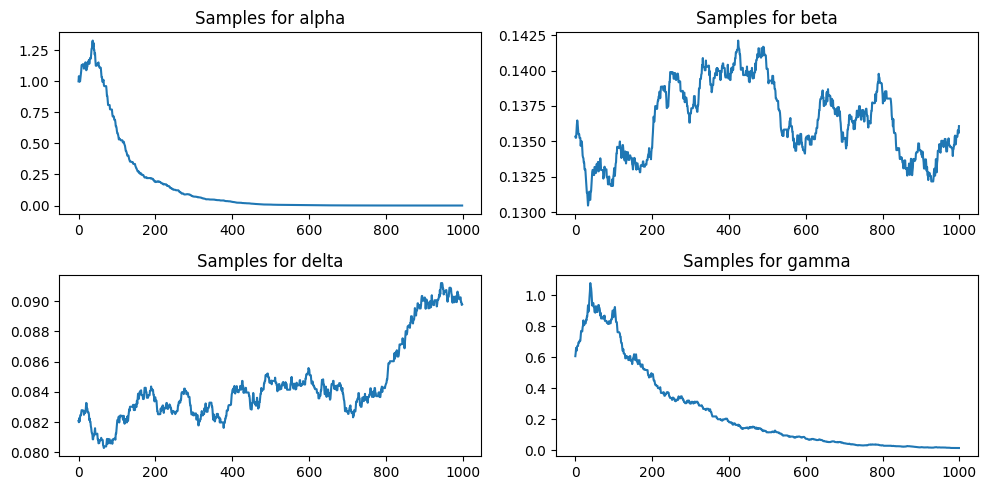

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()

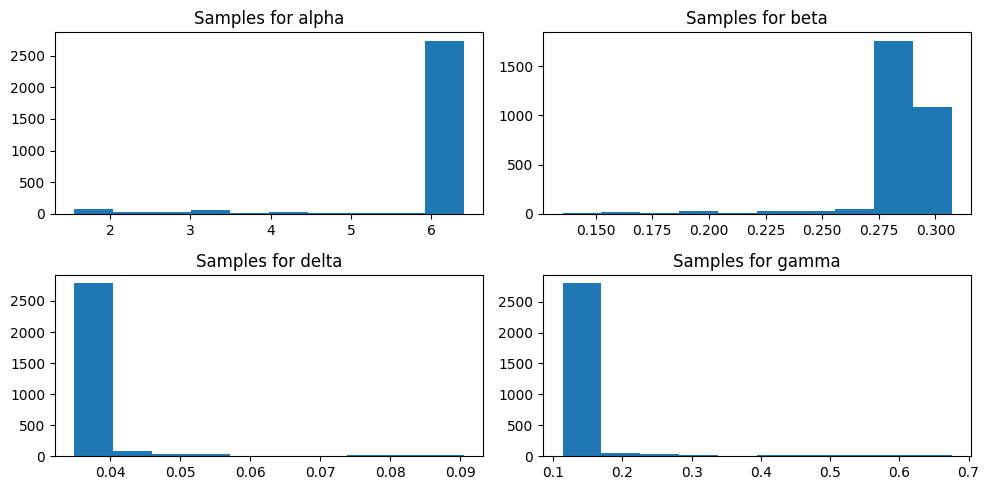

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.hist(jnp.exp(mh_samples[:,i]))
    plt.title(f'Samples for {param}')
    #plt.ylim((0,5))
plt.tight_layout()
plt.show()